In [1]:
import specdist as pi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.collections import LineCollection
from matplotlib.ticker import LogLocator
import re
scientific_notation = pi.scientific_notation
from scipy.linalg import cholesky, LinAlgError
from scipy.linalg import block_diag

import warnings; warnings.simplefilter('ignore')

path_to_figures = "/Users/boris/Work/SPECTRAL-DISTORTIONS/figures/"

xinj_to_mass = 4.698e-4 #m in ev = 4.698e-4 xinj
#1./4.698e-4*2. = 4257.130693912303

# sd_lib_bare = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('bare',sd_lib_bare)


# sd_lib_lyc = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc',sd_lib_lyc)

# sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
# pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)




label_y_firas = r'$y_\mathrm{COBE}=1.5\times 10^{-5}$'
label_mu_firas = r'$\mu_\mathrm{COBE}=9\times 10^{-5}$'
label_fdm = 'Effective Dark Matter Fraction, '+r'$\epsilon f_\mathrm{dm}$'
label_mdm = 'Particle Mass, ' +r'$m_\mathrm{dm}\,\,[\mathrm{eV}]$'
label_xe = 'Free Electron Fraction, '+r'$X_\mathrm{e}$'
label_redshift = 'Redshift, '+r'$z$'
label_mu_dist =  'Chemical Potential, '+r'$\mu$'
label_injection_frequency = "Scaled Injection Frequency, "+ r'$x_{\mathrm{inj,0}}$'
label_scaled_frequency = "Scaled Frequency, "+ r'$x=h\nu/k_{_\mathrm{B}}T_{_\mathrm{CMB}}$'
label_frequency_in_GHz = "Frequency,  "+ r'$\nu \quad [\mathrm{GHz}]$'
label_intensity = "Intensity, "+r'$\Delta I_x \quad [\mathrm{Jy/sr}]$'
label_intensity_kJy = "Intensity, "+r'$\Delta I_x \quad [\mathrm{kJy/sr}]$'
label_injection_energy = "Injection Energy, "+ r'$E_{\mathrm{inj,0}}$' + " [eV]"
xinj_to_Einj = 4.698e-4/2.
label_Gamma = "Decay Rate, "+r"$\Gamma_X\quad[\mathrm{s^{-1}}]$"

label_zX = "Maximum Injection Redshift, "+ r'$z_X$'
sd = pi

In [2]:
sd_lib_xe_history = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('xe_history_200720',sd_lib_xe_history)
sd_lib_lyc_reio = pi.specdist_ct_spectra_lib()
pi.load_ct_spectra_lib('lyc_reio',sd_lib_lyc_reio)

In [8]:
Nx = 400
xi_array = np.logspace(-8,8,Nx)

#Gamma_values = [1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16,1e-17]
Gamma_values = [1e-17]
#gamma_labels = [r'$10^{-8}$',r'$10^{-9}$',r'$10^{-10}$',r'$10^{-11}$',r'$10^{-12}$',r'$10^{-13}$',r'$10^{-14}$',r'$10^{-15}$',r'$10^{-16}$',r'$10^{-17}$']
gamma_labels = [r'$10^{-17}$']





firas = sd.firas()
edges = sd.edges()
a_dict = {}
a_dict['firas'] = firas
a_dict['edges'] = edges
a_dict['add_edges'] = 'no'

# Gamma_values = np.logspace(-17,-8,3)
# for gammas in Gamma_values:
#     xi_array = np.logspace(-16,-10,100)
#     D = sd.pi_run_fisher_constraints([gammas],xi_array,sd_lib_bare,**a_dict)
#     #print(D['curves'][0]['fdm'])

f_dm_fisher_xe_history = sd.pi_run_fisher_constraints(Gamma_values,xi_array,sd_lib_xe_history,**a_dict)
f_dm_fisher_lyc_reio = sd.pi_run_fisher_constraints(Gamma_values,xi_array,sd_lib_lyc_reio,**a_dict)




filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling wi

In [62]:
pi_run_fisher_constraints([1e-17],[1e-4],sd_lib_lyc_reio,**a_dict)

1e-17
[ -6.46958081  -8.33701199  -9.97420219 -11.14190548 -11.75122828
 -11.72025729 -11.03058684  -9.68847283  -7.82311974  -5.50459039
  -2.80408272   0.03844655   2.95127868   5.88651146   8.60699567
  11.15423248  13.36033903  15.23263639  16.78993283  17.95506991
  18.77202609  19.27545313  19.46189443  19.3768288   19.06184065
  18.55236724  17.86902911  17.07131328  16.18287621  15.21288943
  14.22100456  13.19491021  12.19084013  11.20600501  10.22939045
   9.31322821   8.42462843   7.60410156   6.83892427   6.12152453
   5.46594428   4.86253944   4.30942742]
2.965


{'curves': [{'x': [0.0001],
   'fdm': array([1.65869073e-05]),
   'finj': array([2172.55311839])}],
 'Gamma_inj': [1e-17]}

In [63]:
pi_run_fisher_constraints([1e-17],[1e-4],sd_lib_xe_history,**a_dict)

1e-17
[ -6.4738588   -8.34390663  -9.97996036 -11.14664011 -11.75455466
 -11.72510917 -11.03953981  -9.69507631  -7.82411771  -5.51066244
  -2.80481384   0.03793509   2.95551258   5.88821258   8.61170032
  11.16142242  13.36480772  15.24365207  16.7985966   17.96498572
  18.78516124  19.28550668  19.47285131  19.38878069  19.07303475
  18.56246957  17.87783659  17.08142853  16.1942698   15.22122701
  14.22970385  13.20179066  12.19751324  11.21292135  10.23422235
   9.31756775   8.42997607   7.60675272   6.84152516   6.12027197
   5.47105778   4.86803926   4.30985859]
0.00222493482


{'curves': [{'x': [0.0001],
   'fdm': array([1.24397301e-08]),
   'finj': array([1.62935585])}],
 'Gamma_inj': [1e-17]}

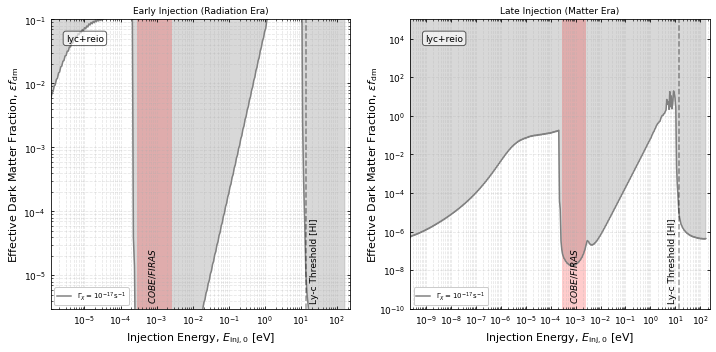

In [6]:
photon_injection_case = 'xe_history_200720'
photon_injection_case = 'lyc_reio'
#Gamma_values = np.logspace(-17,-8,3)
if photon_injection_case == 'bare':
    f_dm_fisher = f_dm_fisher_bare
    case = 'bare'
if photon_injection_case == 'lyc':
    f_dm_fisher = f_dm_fisher_lyc
    case = 'lyc'
if photon_injection_case == 'lyc_reio':
    f_dm_fisher = f_dm_fisher_lyc_reio
    case = 'lyc+reio'
if 'xe_history' in photon_injection_case:
    f_dm_fisher = f_dm_fisher_xe_history
    case = 'lyc+reio xe history'

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>','o','s','d','v','>'])
colors = iter(['grey','forestgreen','b','purple','k','r','b','green','grey'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
label_size = 9
title_size = 11
legend_size = 25
handle_length = 1.5

for ax in (ax1,ax2):
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_ylabel(label_fdm,size=title_size)
    ax.set_xlabel(label_injection_energy,size=title_size)
    ax.yaxis.set_label_coords(-.10,0.5)


    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)

    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True)

    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

    
    
    #ax.axvspan(1.e-3*xinj_to_Einj, 2e-3*xinj_to_Einj,ymin=0.,ymax=0.1, facecolor='blue', alpha=0.2,label=r'$\mathrm{EDGES}$')
    #ax.axvspan(0.5*xinj_to_Einj, 105*xinj_to_Einj,ymin=0.,ymax=0.1,  facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2*xinj_to_Einj, 11.2*xinj_to_Einj,ymin=0.,ymax=1, facecolor='red', alpha=0.2)
    
i = 0
color=iter(cm.viridis(np.linspace(0.7,0,len(Gamma_values))))
for gamma in np.flip(Gamma_values):
#     if i==0:
#         i += 1
#         continue
    col = next(colors)
    mk = next(mklist)
    ls = next(lstyles)
    #ax.plot(f_dm_high_z['curves'][i]['x'],f_dm_high_z['curves'][i]['mu'],c=col,label=r'$\Gamma_X=$'+scientific_notation(f_dm_high_z['Gamma_inj'][i])+r'$\,\mathrm{s^{-1}}$',ls='None', marker=mk,markersize=3)
    if i<5:
        ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],
                 c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=ls)#, marker=,markersize=3)
        ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],
                 c=col,ls=ls)#, marker=mk,markersize=3)
        ax1.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)
    if i<5:
        ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],
                 c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=ls)#, marker=mk,markersize=3,markerfacecolor='None')
        ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],
                 c=col,ls=ls)#, marker=mk,markersize=3,markerfacecolor='None')
        ax2.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)


    i += 1

ax2.text(0.05, 0.95, case , transform=ax2.transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

ax1.text(0.05, 0.95, case , transform=ax1.transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

ax1.set_ylim(3.e-6,1e-1)
ax1.set_xlim(xinj_to_Einj*5e-3,xinj_to_Einj*1e6)

ax2.set_ylim(1.e-10,1e5)
ax2.set_xlim(xinj_to_Einj*1e-6,xinj_to_Einj*1e6)

#leg1 = plt.legend(loc=3,ncol=2,frameon=True,framealpha=0.6,fontsize = 9)
#legend_elements = [Line2D([0], [0], marker='o', color='k', label='best-fit to CT',ls='None',
#                          markerfacecolor='None', markersize=5)]
#leg2 = plt.legend(handles=legend_elements, loc=(0.745,0.6))
ax1.legend(loc=3,ncol=1,frameon=True,framealpha=1.,fontsize = 7)
ax2.legend(loc=3,ncol=1,frameon=True,framealpha=1.,fontsize = 7)

if 'lyc' in photon_injection_case:
    ax2.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
    ax2.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax2.transAxes, fontsize=9,
             verticalalignment='bottom',rotation = 90)
    ax1.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
    ax1.text(0.865, 0.02, 'Ly-c Threshold [HI]' , transform=ax1.transAxes, fontsize=9,
             verticalalignment='bottom',rotation = 90)
ax1.set_title(r'Early Injection (Radiation Era)',fontsize=9)
ax2.set_title(r'Late Injection (Matter Era)',fontsize=9)
ax1.text(0.322, 0.02, r'$COBE/FIRAS$' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax2.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
# ax.add_artist(leg2).tight_layout(pad=3.0)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)

plt.savefig(path_to_figures + '/figures_for_paper_fdm_fisher_'+photon_injection_case+'.pdf')
plt.show()
#plt.close(fig)

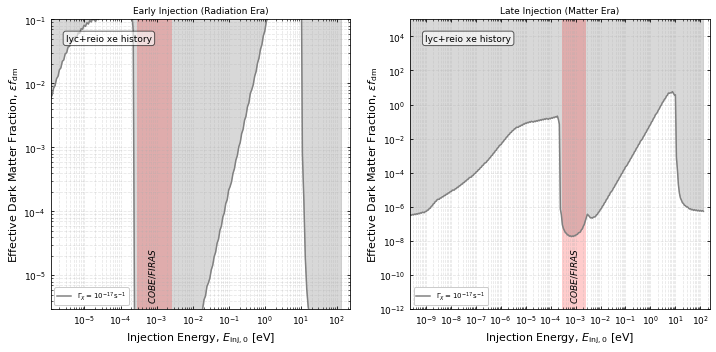

In [10]:
photon_injection_case = 'xe_history_200720'
#photon_injection_case = 'lyc_reio'
#Gamma_values = np.logspace(-17,-8,3)
if photon_injection_case == 'bare':
    f_dm_fisher = f_dm_fisher_bare
    case = 'bare'
if photon_injection_case == 'lyc':
    f_dm_fisher = f_dm_fisher_lyc
    case = 'lyc'
if photon_injection_case == 'lyc_reio':
    f_dm_fisher = f_dm_fisher_lyc_reio
    case = 'lyc+reio'
if 'xe_history' in photon_injection_case:
    f_dm_fisher = f_dm_fisher_xe_history
    case = 'lyc+reio xe history'

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

mklist = iter(['o','s','d','v','>','o','s','d','v','>'])
colors = iter(['grey','forestgreen','b','purple','k','r','b','green','grey'])
lstyles = iter(['-','--','-.',':','-','--','-.',':','-','--','-.',':'])
#fig, ax_array = plt.subplots(2,3,figsize=(30,20))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
label_size = 9
title_size = 11
legend_size = 25
handle_length = 1.5

for ax in (ax1,ax2):
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_ylabel(label_fdm,size=title_size)
    ax.set_xlabel(label_injection_energy,size=title_size)
    ax.yaxis.set_label_coords(-.10,0.5)


    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)

    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=2)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=2)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=3,labelsize=label_size,pad=5)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True)

    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')

    
    
    #ax.axvspan(1.e-3*xinj_to_Einj, 2e-3*xinj_to_Einj,ymin=0.,ymax=0.1, facecolor='blue', alpha=0.2,label=r'$\mathrm{EDGES}$')
    #ax.axvspan(0.5*xinj_to_Einj, 105*xinj_to_Einj,ymin=0.,ymax=0.1,  facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2*xinj_to_Einj, 11.2*xinj_to_Einj,ymin=0.,ymax=1, facecolor='red', alpha=0.2)
    
i = 0
color=iter(cm.viridis(np.linspace(0.7,0,len(Gamma_values))))
for gamma in np.flip(Gamma_values):
#     if i==0:
#         i += 1
#         continue
    col = next(colors)
    mk = next(mklist)
    ls = next(lstyles)
    #ax.plot(f_dm_high_z['curves'][i]['x'],f_dm_high_z['curves'][i]['mu'],c=col,label=r'$\Gamma_X=$'+scientific_notation(f_dm_high_z['Gamma_inj'][i])+r'$\,\mathrm{s^{-1}}$',ls='None', marker=mk,markersize=3)
    if i<5:
        ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],
                 c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=ls)#, marker=,markersize=3)
        ax1.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],
                 c=col,ls=ls)#, marker=mk,markersize=3)
        ax1.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)
    if i<5:
        ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],f_dm_fisher['curves'][i]['fdm'],
                 c=col,label=r'$\Gamma_X=$'+gamma_labels[i]+r'$\,\mathrm{s^{-1}}$',ls=ls)#, marker=mk,markersize=3,markerfacecolor='None')
        ax2.plot(xinj_to_Einj*f_dm_fisher['curves'][i]['x'],-f_dm_fisher['curves'][i]['fdm'],
                 c=col,ls=ls)#, marker=mk,markersize=3,markerfacecolor='None')
        ax2.fill_between(xinj_to_Einj*f_dm_fisher['curves'][i]['x'], np.abs(f_dm_fisher['curves'][i]['fdm']),1e100,color=col,alpha=0.3)


    i += 1

ax2.text(0.05, 0.95, case , transform=ax2.transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

ax1.text(0.05, 0.95, case , transform=ax1.transAxes, fontsize=9, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

ax1.set_ylim(3.e-6,1e-1)
ax1.set_xlim(xinj_to_Einj*5e-3,xinj_to_Einj*1e6)

ax2.set_ylim(1.e-12,1e5)
ax2.set_xlim(xinj_to_Einj*1e-6,xinj_to_Einj*1e6)

#leg1 = plt.legend(loc=3,ncol=2,frameon=True,framealpha=0.6,fontsize = 9)
#legend_elements = [Line2D([0], [0], marker='o', color='k', label='best-fit to CT',ls='None',
#                          markerfacecolor='None', markersize=5)]
#leg2 = plt.legend(handles=legend_elements, loc=(0.745,0.6))
ax1.legend(loc=3,ncol=1,frameon=True,framealpha=1.,fontsize = 7)
ax2.legend(loc=3,ncol=1,frameon=True,framealpha=1.,fontsize = 7)

if 'lyc' in photon_injection_case:
    ax2.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
    ax2.text(0.86, 0.02, 'Ly-c Threshold [HI]' , transform=ax2.transAxes, fontsize=9,
             verticalalignment='bottom',rotation = 90)
    ax1.axvline(5.7895e4*xinj_to_Einj,ls='--',alpha=0.4,c='k')
    ax1.text(0.865, 0.02, 'Ly-c Threshold [HI]' , transform=ax1.transAxes, fontsize=9,
             verticalalignment='bottom',rotation = 90)
ax1.set_title(r'Early Injection (Radiation Era)',fontsize=9)
ax2.set_title(r'Late Injection (Matter Era)',fontsize=9)
ax1.text(0.322, 0.02, r'$COBE/FIRAS$' , transform=ax1.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
ax2.text(0.53, 0.02, r'$COBE/FIRAS$' , transform=ax2.transAxes, fontsize=9,
         verticalalignment='bottom',rotation = 90)
# ax.add_artist(leg2).tight_layout(pad=3.0)
fig.tight_layout()
plt.subplots_adjust(wspace=0.2)

plt.savefig(path_to_figures + '/figures_for_paper_fdm_fisher_'+photon_injection_case+'.pdf')
plt.show()
#plt.close(fig)

In [105]:
sd_lib_xe_history.finj_2d[0][0][0]

8.33180319e-07

In [111]:
np.shape(sd_lib_xe_history.finj_2d)
sd_lib_xe_history.finj_2d[0][0]

[8.33180319e-07,
 8.60581436e-07,
 8.88658322e-07,
 9.17651245e-07,
 9.47590091e-07,
 9.78505725e-07,
 1.01043001e-06,
 1.04339587e-06,
 1.07743728e-06,
 1.11258932e-06,
 1.14888825e-06,
 1.18637148e-06,
 1.22507765e-06,
 1.26504666e-06,
 1.30631971e-06,
 1.34893936e-06,
 1.39294954e-06,
 1.43839563e-06,
 1.48532446e-06,
 1.53378443e-06,
 1.58382549e-06,
 1.63549922e-06,
 1.68885891e-06,
 1.74395956e-06,
 1.80085798e-06,
 1.85961283e-06,
 1.92028467e-06,
 1.98293607e-06,
 2.04763161e-06,
 2.114438e-06,
 2.1834241e-06,
 2.25466105e-06,
 2.32822228e-06,
 2.40418365e-06,
 2.48262347e-06,
 2.5636226e-06,
 2.64726457e-06,
 2.73363561e-06,
 2.82282478e-06,
 2.91492403e-06,
 3.01002833e-06,
 3.10823574e-06,
 3.20964751e-06,
 3.31436821e-06,
 3.42250582e-06,
 3.53417185e-06,
 3.64948144e-06,
 3.76855348e-06,
 3.89151077e-06,
 4.01848008e-06,
 4.14959236e-06,
 4.28498281e-06,
 4.42479103e-06,
 4.56916121e-06,
 4.71824223e-06,
 4.87218783e-06,
 5.03115677e-06,
 5.195313e-06,
 5.36482581e-06,
 5.

In [108]:
np.shape(sd_lib_lyc_reio.finj_2d)
sd_lib_lyc_reio.finj_2d[0][0]

[289.7]

In [106]:
def find_nearests(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if array[idx]>value:
        idxp =idx
        idxm = idx-1
    else:
        idxm = idx
        idxp = idx+1
    if idxp == len(array):
        idxm -= 1
        idxp -= 1
    return (idxm,idxp)

def GetSpectra(Gamma_inj_asked,x_inj_asked,x_asked,specdist_ct_spectra_lib):
    r1 = (Gamma_inj_asked - specdist_ct_spectra_lib.Gamma_inj_min)
    r2 = (specdist_ct_spectra_lib.Gamma_inj_max - Gamma_inj_asked)
    r3 = (x_inj_asked - specdist_ct_spectra_lib.x_inj_min)
    r4 = (specdist_ct_spectra_lib.x_inj_max - x_inj_asked)

    if (r1 < 0) or (r2 < 0) or (r3 < 0) or (r4 < 0):
        print('filling with nans')
        array_x_asked =  np.empty(len(x_asked))
        array_x_asked[:] = np.nan
        array_S_result = np.empty(len(x_asked))
        array_S_result[:] =  np.nan
        F_gamma_asked_xinj_asked = np.nan

    else:
        X_2d =  specdist_ct_spectra_lib.X_2d
        DI_2d = specdist_ct_spectra_lib.DI_2d
        finj_2d = specdist_ct_spectra_lib.finj_2d

        Gamma_values = specdist_ct_spectra_lib.Gamma_values
        x_inj_values =  specdist_ct_spectra_lib.x_inj_values
        # print(Gamma_values)
        # print(x_inj_values)
        # print(find_nearests(Gamma_values, Gamma_inj_asked))
        id_gamma_low = find_nearests(Gamma_values, Gamma_inj_asked)[0]
        id_gamma_high = find_nearests(Gamma_values, Gamma_inj_asked)[1]
#         if id_gamma_low == -1 and id_gamma_high == 0:
#             id_gamma_low = id_gamma_high

        id_xinj_low = find_nearests(x_inj_values, x_inj_asked)[0]
        id_xinj_high = find_nearests(x_inj_values, x_inj_asked)[1]
        
        print(id_gamma_low,id_gamma_high,id_xinj_low,id_xinj_high)

        #DI_2d[id_gamma_low][id_xinj_low]  #DI_2d[id_gamma_low][id_xinj_high]
        #X_2d[id_gamma_low][id_xinj_low]   #X_2d[id_gamma_low][id_xinj_high]

        #DI_2d[id_gamma_high][id_xinj_low]  #DI_2d[id_gamma_high][id_xinj_high]
        #X_2d[id_gamma_high][id_xinj_low]   #X_2d[id_gamma_high][id_xinj_high]
        S = [[X_2d[id_gamma_low][id_xinj_low],DI_2d[id_gamma_low][id_xinj_low]],[X_2d[id_gamma_low][id_xinj_high],DI_2d[id_gamma_low][id_xinj_high]],[X_2d[id_gamma_high][id_xinj_low],DI_2d[id_gamma_high][id_xinj_low]],[X_2d[id_gamma_high][id_xinj_high],DI_2d[id_gamma_high][id_xinj_high]]]
        F = [finj_2d[id_gamma_low][id_xinj_low],
             finj_2d[id_gamma_low][id_xinj_high],
             finj_2d[id_gamma_high][id_xinj_low],
             finj_2d[id_gamma_high][id_xinj_high]]
        dict = {
        "gamma_low": Gamma_values[id_gamma_low],
        "gamma_high": Gamma_values[id_gamma_high],
        "xinj_low": x_inj_values[id_xinj_low],
        "xinj_high": x_inj_values[id_xinj_high],
        "spectra": S,
        "finj": F
        }
        
        #print(F)

        gamma_low = dict["gamma_low"]
        gamma_high = dict["gamma_high"]
        xinj_low = dict["xinj_low"]
        xinj_high = dict["xinj_high"]
        S = dict["spectra"]
        F = dict["finj"]
        
        #print(gamma_low)
        #print(gamma_high)

        S_gamma_low_xinj_low = S[0]
        S_gamma_low_xinj_high = S[1]
        S_gamma_high_xinj_low = S[2]
        S_gamma_high_xinj_high = S[3]

        F_gamma_low_xinj_low = F[0][0]
        F_gamma_low_xinj_high = F[1][0]
        F_gamma_high_xinj_low = F[2][0]
        F_gamma_high_xinj_high = F[3][0]

        Gamma_asked = Gamma_inj_asked
        xinj_asked = x_inj_asked

        #check if nan in any of the arrays:
        Arrays_list = [S_gamma_low_xinj_low,
                      S_gamma_low_xinj_high,
                      S_gamma_high_xinj_low,
                      S_gamma_high_xinj_high]
        has_nan = False
        for p in Arrays_list:
            array = p
            array_sum = np.sum(array)
            has_nan += np.isnan(array_sum)
        if has_nan:
            #print('filling with nans')
            array_x_asked =  np.empty(len(x_asked))
            array_x_asked[:] = np.nan
            array_S_result = np.empty(len(x_asked))
            array_S_result[:] =  np.nan
            F_gamma_asked_xinj_asked = np.nan
        else:
            nx = int(1e4)


            ############### xinj_low
            new_x_min = np.maximum(np.min(S_gamma_low_xinj_low[0]),np.min(S_gamma_high_xinj_low[0]))
            new_x_max = np.minimum(np.max(S_gamma_low_xinj_low[0]),np.max(S_gamma_high_xinj_low[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]


            f_gamma_low = interp1d(S_gamma_low_xinj_low[0], S_gamma_low_xinj_low[1])
            f_gamma_high = interp1d(S_gamma_high_xinj_low[0], S_gamma_high_xinj_low[1])

            new_S_gamma_low = f_gamma_low(new_x_array)
            new_S_gamma_high = f_gamma_high(new_x_array)

            if gamma_low == Gamma_asked:
                w = 1.
            elif gamma_high == Gamma_asked:
                w = 0.
            else:
                #w = (gamma_high - Gamma_asked)/(gamma_high - gamma_low)
                w = (np.log(gamma_high) - np.log(Gamma_asked))/(np.log(gamma_high) - np.log(gamma_low))
            new_S_gamma_asked = w*new_S_gamma_low + (1.-w)*new_S_gamma_high
#             print('xinj _low : w_gamma = %.14e'%w)



            S_gamma_asked_xinj_low = [[],[]]
            S_gamma_asked_xinj_low[0] = new_x_array
            S_gamma_asked_xinj_low[1] = new_S_gamma_asked
            
            print('w=%.4e'%w)
            print('gamma_low= %.4e'%gamma_low)
            print('gamma_high= %.4e'%gamma_high)
            print('F_gamma_low_xinj_low= %.4e'%F_gamma_low_xinj_low)
            print('F_gamma_high_xinj_low= %.4e'%F_gamma_high_xinj_low)
            F_gamma_asked_xinj_low = w*F_gamma_low_xinj_low + (1.-w)*F_gamma_high_xinj_low
            print('F_gamma_asked_xinj_low=%.4e'%F_gamma_asked_xinj_low)
            ############# xinj_high

            new_x_min = np.maximum(np.min(S_gamma_low_xinj_high[0]),np.min(S_gamma_high_xinj_high[0]))
            new_x_max = np.minimum(np.max(S_gamma_low_xinj_high[0]),np.max(S_gamma_high_xinj_high[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]

            f_gamma_low = interp1d(S_gamma_low_xinj_high[0], S_gamma_low_xinj_high[1])
            f_gamma_high = interp1d(S_gamma_high_xinj_high[0], S_gamma_high_xinj_high[1])

            new_S_gamma_low = f_gamma_low(new_x_array)
            new_S_gamma_high = f_gamma_high(new_x_array)

            if gamma_low == Gamma_asked:
                w = 1.
            elif gamma_high == Gamma_asked:
                w = 0.
            else:
                #w = (gamma_high - Gamma_asked)/(gamma_high - gamma_low)
                w = (np.log(gamma_high) - np.log(Gamma_asked))/(np.log(gamma_high) - np.log(gamma_low))
#             #w = (gamma_high - Gamma_asked)/(gamma_high - gamma_low)
#             w = (np.log(gamma_high) - np.log(Gamma_asked))/(np.log(gamma_high) - np.log(gamma_low))
            new_S_gamma_asked = w*new_S_gamma_low + (1.-w)*new_S_gamma_high
#             print('xinj _high : w_gamma = %.14e'%w)

            S_gamma_asked_xinj_high = [[],[]]
            S_gamma_asked_xinj_high[0] = new_x_array
            S_gamma_asked_xinj_high[1] = new_S_gamma_asked

            F_gamma_asked_xinj_high = w*F_gamma_low_xinj_low + (1.-w)*F_gamma_high_xinj_high

            ############# interpolation between xinjs
            new_x_min = np.maximum(np.min(S_gamma_asked_xinj_low[0]),np.min(S_gamma_asked_xinj_high[0]))
            new_x_max = np.minimum(np.max(S_gamma_asked_xinj_low[0]),np.max(S_gamma_asked_xinj_high[0]))
            new_x_array = np.logspace(np.log10(new_x_min),np.log10(new_x_max),nx)
            new_x_array = new_x_array[1:-1]

            f_xinj_low = interp1d(S_gamma_asked_xinj_low[0], S_gamma_asked_xinj_low[1])
            f_xinj_high = interp1d(S_gamma_asked_xinj_high[0], S_gamma_asked_xinj_high[1])

            new_S_xinj_low = f_xinj_low(new_x_array)
            new_S_xinj_high = f_xinj_high(new_x_array)

            #w = (xinj_high - xinj_asked)/(xinj_high - xinj_low)
            w = (np.log(xinj_high) - np.log(xinj_asked))/(np.log(xinj_high) - np.log(xinj_low))
#             print('xinj_high = %.14e'%xinj_high)
#             print('w_xinj = %.14e'%w)
            
            new_S_xinj_asked = w*new_S_xinj_low + (1.-w)*new_S_xinj_high

            S_gamma_asked_xinj_asked = [[],[]]
            S_gamma_asked_xinj_asked[0] = new_x_array
            S_gamma_asked_xinj_asked[1] = new_S_xinj_asked

            F_gamma_asked_xinj_asked = w*F_gamma_asked_xinj_low + (1.-w)*F_gamma_asked_xinj_high


            f_gamma_asked_xinj_asked = interp1d(S_gamma_asked_xinj_asked[0], S_gamma_asked_xinj_asked[1])
            ########### get spectra at required x values
            bound_x_min = np.min(S_gamma_asked_xinj_asked[0])
            bound_x_max = np.max(S_gamma_asked_xinj_asked[0])

            array_x_asked = np.asarray(x_asked)

            min_x_asked = np.min(array_x_asked)
            max_x_asked = np.max(array_x_asked)

            id_min = 0
            id_max = None
            if min_x_asked < bound_x_min:
                id_min = find_nearests(array_x_asked, bound_x_min)[1]
            if max_x_asked > bound_x_max:
                id_max = find_nearests(array_x_asked, bound_x_max)[0]
            array_x_asked = array_x_asked[id_min:id_max]

            array_S_result = f_gamma_asked_xinj_asked(array_x_asked)

    r_dict = {"x":array_x_asked,
              "DI": array_S_result,
              "finj": F_gamma_asked_xinj_asked}

    return r_dict



0 1 33 34
w=1.0000e+00
gamma_low= 1.0000e-17
gamma_high= 1.5264e-17
F_gamma_low_xinj_low= 2.9650e+00
F_gamma_high_xinj_low= 3.8280e+00
F_gamma_asked_xinj_low=2.9650e+00
-1 0 53 54
w=1.0000e+00
gamma_low= 1.0000e-17
gamma_high= 1.0000e-17
F_gamma_low_xinj_low= 2.2249e-03
F_gamma_high_xinj_low= 2.2249e-03
F_gamma_asked_xinj_low=2.2249e-03
2.965
0.00222493482


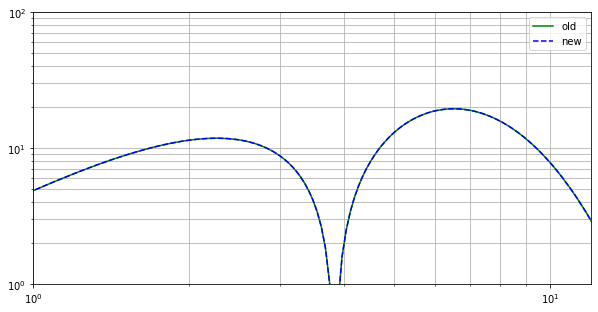

In [107]:
i=32

x_asked = np.logspace(np.log10(1e-5),np.log10(1e3),1000)
gamma_asked = 1.e-17
# xinj_asked = 7.19685673001151e-01
xinj_asked = 1.e-4
# new runs 6.449e+05
#xinj_old_run i = 189 #249451
# S_bare = pi.GetSpectra(gamma_asked,xinj_asked,x_asked,sd_lib_bare)
# S_mu_fit = pi.GetSpectra(gamma_asked,xinj_asked,x_asked,sd_lib_mu_fit)
S_lyc_reio = GetSpectra(gamma_asked,xinj_asked,x_asked,sd_lib_lyc_reio)
S_xe_history = GetSpectra(gamma_asked,xinj_asked,x_asked,sd_lib_xe_history)

fig, (ax) = plt.subplots(1,1,figsize=(10,5))
# S = S_bare
# plt.plot(S['x'],np.abs(S['DI']),c='k',label='bare')
# S = S_mu_fit
# plt.plot(S['x'],np.abs(S['DI']),c='r',label = 'mu_fit',ls='--')
S = S_lyc_reio
print(S['finj'])
plt.plot(S['x'],np.abs(S['DI']),c='g',label = 'old',ls='-')
S = S_xe_history
print(S['finj'])

# plt.plot(x_ct[26],np.abs(DI_ct_bare[26]),c='r',label = 'tot',ls='-.')
# plt.plot(x_ct[26],np.abs(DI_ct_hubble[26]),c='k',label = 'hubble-reio',ls='-.')
# # plt.plot(x_ct[26],np.abs(DI_ct_bare[26]-DI_ct_hubble[26]),c='orange',label = 'bare',ls='-.')
plt.plot(S['x'],np.abs(S['DI']),c='b',label = 'new',ls='--')
# plt.plot(x_ct[i],DI_ct[i],c='orange',label = 'i',ls='-',
#            marker='o',markersize=0.1)
# plt.plot(x_ct[i+1],DI_ct[i+1],c='r',label = 'i+1',ls='-',
#            marker='o',markersize=0.1)

# plt.plot(S['x'],-S['DI'],c='b',label = 'interp',ls=':')
# plt.plot(x_ct[i],-DI_ct[i],c='orange',label = 'i',ls=':',
#            marker='o',markersize=0.1)
# plt.plot(x_ct[i+1],-DI_ct[i+1],c='r',label = 'i+1',ls=':',
#            marker='o',markersize=0.1)

# # plt.plot(x_ct[26],np.abs(DI_ct_hubble[26]),c='k',label = 'bare',ls='-.')
#plt.plot(CT_X_new,np.abs(CT_I_new),c='magenta',label = 'ct new',ls='-')
#plt.plot(CT_X_old,np.abs(CT_I_old),c='r',label = 'ct old',ls='-.')
#plt.plot(CT_X_sirius,np.abs(CT_I_sirius),c='orange',label = 'sirius',ls='-.')
plt.loglog()
plt.grid(which='both')
plt.ylim(1e0,1e2)
plt.xlim(1e0,1.2e1)
plt.legend(loc=1)
#plt.savefig(path_to_figures + '/figures_for_paper_tests.pdf')



In [68]:
firas = pi.firas()
firas.firas_x

array([ 1.19854114,  1.4361374 ,  1.67901357,  1.91660983,  2.15420609,
        2.39708227,  2.63467853,  2.87755471,  3.11515097,  3.35274723,
        3.59562341,  3.83321967,  4.07081593,  4.3136921 ,  4.55128836,
        4.79416454,  5.0317608 ,  5.26935706,  5.51223324,  5.7498295 ,
        5.98742576,  6.23030194,  6.4678982 ,  6.71077437,  6.94837063,
        7.18596689,  7.42884307,  7.66643933,  7.90403559,  8.14691177,
        8.38450803,  8.62738421,  8.86498047,  9.10257673,  9.3454529 ,
        9.58304916,  9.82592534, 10.0635216 , 10.30111786, 10.54399404,
       10.7815903 , 11.01918656, 11.26206274])

In [24]:
CT_hubble = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr/outputs/Dn.cooling.photon_inj.PDE_ODE.new_state.hubble.tmp.dat')
CT = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr/outputs/Dn.cooling.photon_inj.PDE_ODE.new_state.tmp.dat')

CT_I_new = CT[:,5]-CT_hubble[:,5]
CT_X_new = CT[:,0]

CT_hubble = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr/outputs/Dn.cooling.photon_inj.PDE_ODE.old_state.hubble.tmp.dat')
CT = np.loadtxt('/Users/boris/Work/SPECTRAL-DISTORTIONS/cosmotherm.rel_corr/outputs/Dn.cooling.photon_inj.PDE_ODE.old_state.tmp.dat')

CT_I_old = CT[:,5]-CT_hubble[:,5]
CT_X_old = CT[:,0]



In [49]:
strg = "1.000e-17"

DI_ct = []
DI_ct_bare = []
DI_ct_hubble = []
DI_ct_bare_final = []
DI_ct_hubble_final = []
filename = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/ct_database/case_xe_history_180720/xe_history_180720_G_'+strg+'/spectra_xe_history_180720_G_'+strg+'_DI_ct.txt'
filename_hubble ='/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/ct_database/case_xe_history_180720/xe_history_180720_hubble_G_'+strg+'/spectra_xe_history_180720_hubble_G_'+strg+'_DI_ct.txt'
with open(filename) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                DI_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    DI_cti = float(s)
                    DI_ct_p.append(DI_cti)
                DI_ct_p = np.asarray(DI_ct_p)
            DI_ct_bare.append(DI_ct_p)
with open(filename_hubble) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                DI_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    DI_cti = float(s)
                    DI_ct_p.append(DI_cti)
                DI_ct_p = np.asarray(DI_ct_p)
            DI_ct_hubble.append(DI_ct_p)
for (p_bare,p_hubble) in zip(DI_ct_bare,DI_ct_hubble):
    DI_ct.append(p_bare-p_hubble)
    DI_ct_hubble_final.append(p_hubble)
    DI_ct_bare_final.append(p_bare)

#read x array
x_ct = []
filename = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/ct_database/case_xe_history_180720/xe_history_180720_G_'+strg+'/spectra_xe_history_180720_G_'+strg+'_x_ct.txt'
with open(filename) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                x_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    x_cti = float(s)
                    x_ct_p.append(x_cti)
                x_ct_p = np.asarray(x_ct_p)
            x_ct.append(x_ct_p)

In [50]:
x_inj = []
filename = '/Users/boris/Work/SPECTRAL-DISTORTIONS/specdist/specdist/data/ct_database/case_xe_history_180720/xe_history_180720_G_'+strg+'/spectra_xe_history_180720_G_'+strg+'_xinj_ct.txt'
with open(filename) as f:
    for line in f:
        ls = line.strip()
        if ls:
            if "#" in ls:
                continue
            else:
                x_ct_p = []
                l = re.split('\t',ls)
                l = [e for e in l if e]
                #print(l)
                for s in l:
                    x_cti = float(s)
                    x_ct_p.append(x_cti)
                x_ct_p = np.asarray(x_ct_p)
            x_inj.append(x_ct_p[0])
#x_inj

In [51]:
x_inj[32]

0.416

In [57]:
x_inj[33]

0.7197

[[<matplotlib.axes._subplots.AxesSubplot object at 0x1825b91f50>
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans
filling with nans

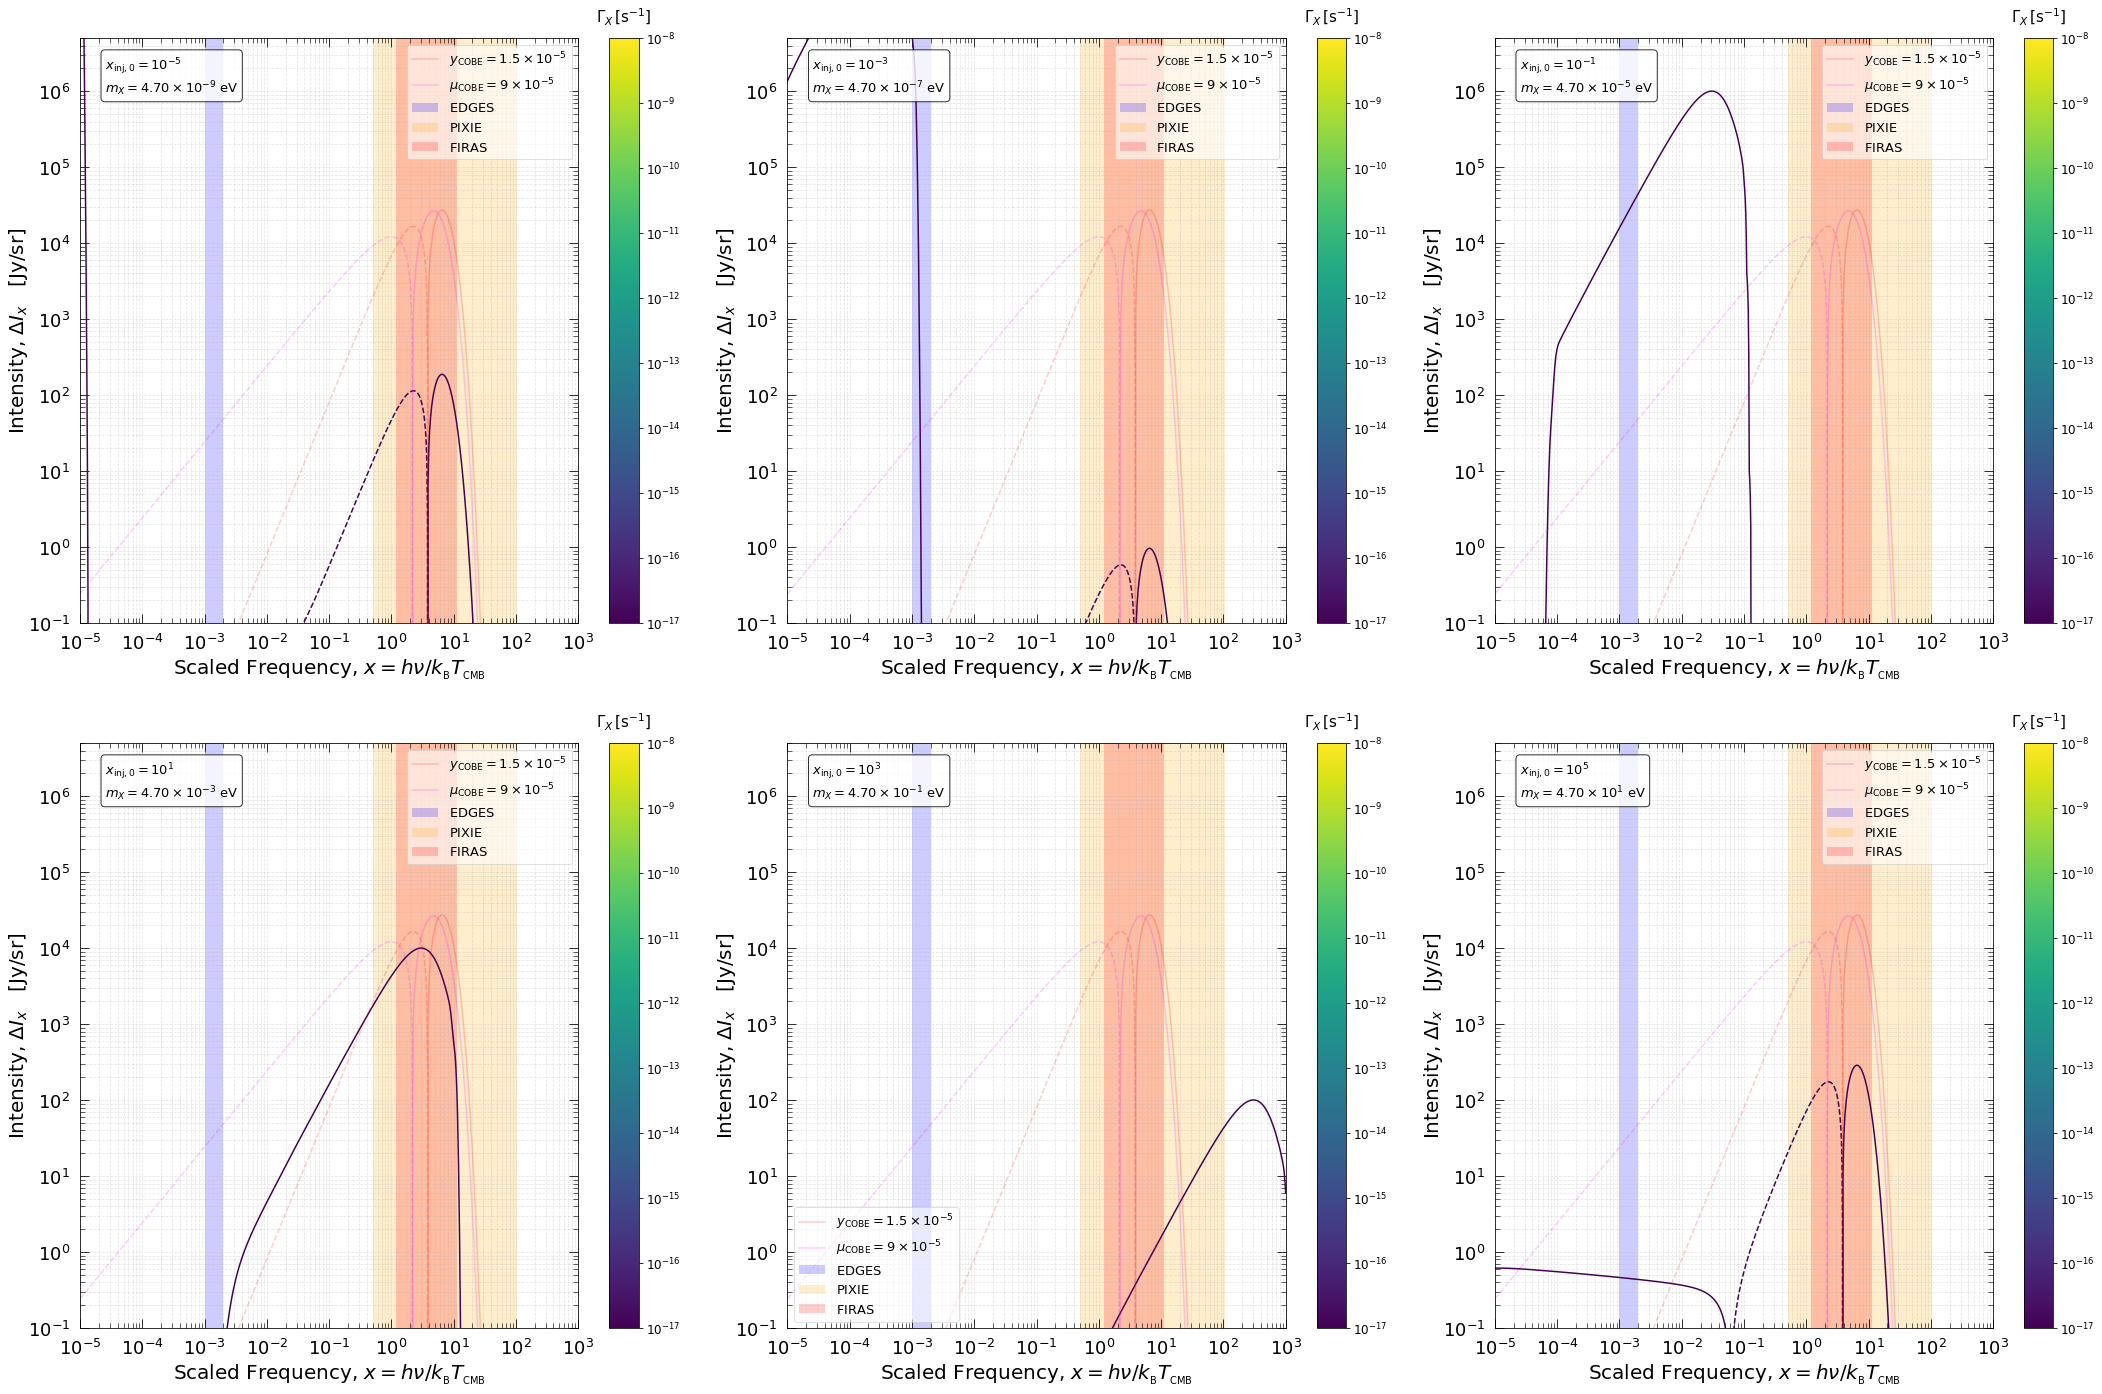

In [88]:
# Gamma_inj_min = 1e-17
# Gamma_inj_max = 1e-8
# N_Gamma_inj = 50
# Gamma_values = np.logspace(np.log10(Gamma_inj_min),np.log10(Gamma_inj_max),N_Gamma_inj)

xinj_asked_array = [1.e-5,1e-3,1e-1,1e1,1e3,1e5]

# x_min = 1.e-6
# x_max = 1.5e4
# ymin = 1.e-18
# ymax = 1.5e-3
x_min = 1.e-5
x_max = 1.e3
ymin = 1.e-1
ymax = 5e-6*1e6*1e6

ngamma = 100
firas = pi.firas()


fig, ax_array = plt.subplots(2,3,figsize=(30,20))
label_size = 18
title_size = 20
legend_size = 25
handle_length = 1.5
my_cmap =  cm.get_cmap('viridis')
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=1))


print(ax_array)
for (xinj_asked,ax) in zip(xinj_asked_array,ax_array.reshape(-1)):



    ax.set_xlim(x_min,x_max)
    ax.set_ylim(ymin,ymax)
    ax.set_xscale('log')
    ax.set_yscale('log')


    ax.set_xlabel(label_scaled_frequency,size=title_size)
    ax.set_ylabel(label_intensity,size=title_size)
    ax.yaxis.set_label_coords(-.1,0.5)
    
    cbar = fig.colorbar(sm,ax=ax)
    cbar.set_ticks(1./9.*np.arange(0,10))
    cbar.ax.set_yticklabels([r'$10^{-17}$',r'$10^{-16}$',r'$10^{-15}$',r'$10^{-14}$',r'$10^{-13}$',r'$10^{-12}$',r'$10^{-11}$',r'$10^{-10}$',r'$10^{-9}$',r'$10^{-8}$'],size=12)
    cbar.ax.set_title(r'$\Gamma_X\,[\mathrm{s}^{-1}]$',size=15,pad=15)





#     ax.tick_params(axis = 'x',which='both',length=5,direction='in', pad=10)
#     ax.tick_params(axis = 'y',which='both',length=5,direction='in', pad=10)

#     plt.setp(ax.get_yticklabels(), rotation='horizontal', fontsize=label_size)
#     plt.setp(ax.get_xticklabels(), fontsize=label_size)
#     plt.tick_params(axis='both', which='major', labelsize=label_size,length=9,direction='in')
#     plt.tick_params(axis='both', which='minor', labelsize=label_size,length=5,direction='in')
#     majors = [0, 1, 5]
# #     majors = [0, 1, 5]
#    ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
#     for label in ax.xaxis.get_ticklabels()[::2]:
#         label.set_visible(False) #(3)


#     ax.xaxis.set_ticks_position('both')
#     ax.yaxis.set_ticks_position('both')

#     ax.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
#     ax.xaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=15))
#     locmin = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) ,
#                                           numticks=12)
#     ax.xaxis.set_minor_locator(locmin)
#     ax.yaxis.set_minor_locator(locmin)
#     ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
#     ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    ax.axvspan(1.e-3, 2e-3, facecolor='blue', alpha=0.2,label=r'$\mathrm{EDGES}$')
    ax.axvspan(0.5, 105, facecolor='orange', alpha=0.2,label=r'$\mathrm{PIXIE}$')
    ax.axvspan(1.2, 11.2, facecolor='red', alpha=0.2,label=r'$\mathrm{FIRAS}$')
    #ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
    #ax.grid(  which="both", alpha=0.3, linestyle='--')


    
    color=iter(cm.viridis(np.linspace(1,0,ngamma)))

    x_asked = np.logspace(np.log10(x_min),np.log10(x_max),1000)
    
    
    m_dec_in_ev = xinj_to_mass*xinj_asked
    str_m_dec_in_ev =  str("%.3e"%m_dec_in_ev)
    text_mdec = r'$m_X=$'+scientific_notation(m_dec_in_ev)+r'$\,\,\mathrm{eV}$'

    
    xinj_ct_for_plot = xinj_asked
    


    for Gamma_asked in np.logspace(-17,-8,ngamma)[::-1]:

        #S = pi.GetSpectra(Gamma_asked,xinj_asked,x_asked,sd_lib_lyc_reio)
        S = pi.GetSpectra(Gamma_asked,xinj_asked,x_asked,sd_lib_xe_history)
        col = next(color)
#         ax.plot(S["x"],S["DI"]/S["finj"],c=col)
#         ax.plot(S["x"],-S["DI"]/S["finj"],c=col,ls='--')
        ax.plot(S["x"],S["DI"],c=col)
        ax.plot(S["x"],-S["DI"],c=col,ls='--')
        #ax.plot(S["x"],np.abs(S["DI"]),c=next(color))


    ax.loglog()

    text_gamma_str1 = r'$x_\mathrm{inj,0}= $'  + scientific_notation(xinj_asked)
    text_gamma_str = '\n'.join((text_gamma_str1,text_mdec))


    ax.text(0.05, 0.97, text_gamma_str, transform=ax.transAxes, fontsize=13, verticalalignment='top',
          bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    
    Y = pi.GetYSpecDistAtTandX(firas.firas_y_1996_95_cl,pi.firas_T0_bf,x_asked)*1e6
    ax.plot(x_asked,Y,c='r',alpha = 0.2,label = label_y_firas)
    ax.plot(x_asked,-Y,c='r',ls='--',alpha = 0.2)

    MU_chluba = pi.GetMuSpecDistAtTandX_chluba(firas.firas_mu_1996_95_cl,pi.firas_T0_bf,x_asked)*1e6
    ax.plot(x_asked,MU_chluba,c='magenta',alpha = 0.2,label=label_mu_firas)
    ax.plot(x_asked,-MU_chluba,c='magenta',ls='--',alpha = 0.2)
    
    
    if xinj_asked==1e3:
        lloc = 3
    else:
        lloc =1
    legend1 = ax.legend(loc=lloc,ncol=1,frameon=True,framealpha=0.6,fontsize = 13)
# my_cmap = cm.viridis
# sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0., vmax=1.))

# # cbar = plt.colorbar(sm,ax=ax,ticks=[0.,0.5,1.])#,orientation='horizontal',anchor=(0.,0.),shrink=0.5)
# # cbar.ax.set_yticklabels(['0','1','2'])
# #cbar.set_label(r'$\Gamma_\mathrm{inj}$', rotation=0)
# cbar= fig.colorbar(sm, ax=ax_array.flat,orientation='horizontal')
# cbar.ax.set_xticks([0.,0.5,1.])
# cbar.ax.set_xticklabels(['0','1','2'])
# cbar.set_label(r'$\Gamma_\mathrm{inj}$', rotation=0)

    ax.yaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.yaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)
        
    ax.yaxis.set_tick_params(right='on',which='minor',direction='in',length=5)
    ax.xaxis.set_tick_params(top='on',which='minor',direction='in',length=5)
    ax.yaxis.set_tick_params(right='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)
    ax.xaxis.set_tick_params(top='on',which='major',direction='in',length=9,labelsize=label_size,pad=10)

    # manipulate x-axis ticks and labels
    ax.xaxis.set_major_locator(LogLocator(numticks=15)) #(1)
    ax.xaxis.set_minor_locator(LogLocator(numticks=15,subs=np.arange(2,10))) #(2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(True) #(3)
        

        
    ax.grid( b=True, which="both", alpha=0.3, linestyle='--')
#     plt.tick_params(axis='both', which='major', labelsize=label_size,length=9,direction='in')
#     plt.tick_params(axis='both', which='minor', labelsize=label_size,length=5,direction='in')
fig.tight_layout(pad=3.0)
str_x = str("%.3e"%xinj_ct_for_plot)
#plt.savefig(path_to_figures + '/spectra_for_paper_xinj_lyc_reio.pdf')
plt.show()
plt.close(fig)


